In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import matplotlib_inline
import seaborn as sns

sns.set(style="whitegrid")
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

# Read in data

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "tutorial_performance_data")

In [3]:
df = pd.read_csv(os.path.join(data_dir, "all_data.csv"))
df["short_name"] = df["name"].apply(lambda x: x[:21])
df["memory_increase"] = df["max_mem"] - df["start_mem"]
df["datetime"] = pd.to_datetime(df["datetime"])

In [4]:
df["tmp"] = df.apply(lambda x: x["name"] if x.loc["ran_successfully"] else "", axis=1)
df["ran_successfully"].mean()

0.9717781402936378

In [5]:
df["name_if_ran"] = df.apply(
    lambda x: x.loc["name"] if x.loc["ran_successfully"] else "", axis=1
)

# Identifies runs where the same set of tutorials completed
# Used to make sure we don't compare aggregated data from
# runs where different tutorials were run
df["set_of_tutorials_run_hash"] = df.groupby("fname")["name_if_ran"].transform(
    lambda x: hash("".join(x.sort_values().values))
)
df.head()

,name,ran_successfully,runtime,start_mem,max_mem,mode,commit_hash,datetime,fname,short_name,memory_increase,tmp,name_if_ran,set_of_tutorials_run_hash
0,GIBBON_for_efficient_batch_entropy_search,True,17.157764,114.222656,601.785156,smoke-test,68547512,2023-02-21 20:00:29.634413,smoke-test_68547512_2023-02-21 20:00:29.634413...,GIBBON_for_efficient_,487.562500,GIBBON_for_efficient_batch_entropy_search,GIBBON_for_efficient_batch_entropy_search,113300870890167505
1,Multi_objective_multi_fidelity_BO,True,42.191367,115.996094,597.347656,smoke-test,68547512,2023-02-21 20:00:29.634413,smoke-test_68547512_2023-02-21 20:00:29.634413...,Multi_objective_multi,481.351562,Multi_objective_multi_fidelity_BO,Multi_objective_multi_fidelity_BO,113300870890167505
2,batch_mode_cross_validation,True,3.063518,116.746094,555.121094,smoke-test,68547512,2023-02-21 20:00:29.634413,smoke-test_68547512_2023-02-21 20:00:29.634413...,batch_mode_cross_vali,438.375000,batch_mode_cross_validation,batch_mode_cross_validation,113300870890167505
3,bo_with_warped_gp,True,11.943523,117.472656,570.277344,smoke-test,68547512,2023-02-21 20:00:29.634413,smoke-test_68547512_2023-02-21 20:00:29.634413...,bo_with_warped_gp,452.804688,bo_with_warped_gp,bo_with_warped_gp,113300870890167505
4,bope,False,NaN,NaN,NaN,smoke-test,68547512,2023-02-21 20:00:29.634413,smoke-test_68547512_2023-02-21 20:00:29.634413...,bope,NaN,,,113300870890167505


# Plot performance metrics over time

In [6]:
per_hash_data = (
    df.groupby(["mode", "set_of_tutorials_run_hash"])
    .agg(
        n_runs=("fname", lambda x: len(x.drop_duplicates())),
        most_recent_run=("datetime", "max"),
    )
    .reset_index()
)
# loosen this as more data comes in
per_hash_data["keep"] = (per_hash_data["n_runs"] > 2) & (
    per_hash_data["most_recent_run"] > "2023-02-24"
)
per_hash_data.head()

,mode,set_of_tutorials_run_hash,n_runs,most_recent_run,keep
0,smoke-test,-3485581563173801134,56,2023-11-10 15:43:32.142914,True
1,smoke-test,-2502676891705361550,28,2023-12-09 01:43:55.055422,True
2,smoke-test,-2426896418691041860,145,2023-09-03 13:48:19.917488,True
3,smoke-test,113300870890167505,8,2023-02-27 22:21:43.757440,True
4,smoke-test,2811912383003052195,19,2023-03-17 15:18:35.996298,True


In [7]:
hashes_to_plot = per_hash_data.loc[
    per_hash_data["keep"], ["mode", "set_of_tutorials_run_hash"]
]
hashes_to_plot.head()

,mode,set_of_tutorials_run_hash
0,smoke-test,-3485581563173801134
1,smoke-test,-2502676891705361550
2,smoke-test,-2426896418691041860
3,smoke-test,113300870890167505
4,smoke-test,2811912383003052195


In [8]:
time_series_data_wide = (
    df.merge(hashes_to_plot)
    .groupby("fname")
    .agg(
        mode=("mode", "first"),
        set_of_tutorials_run_hash=("set_of_tutorials_run_hash", "first"),
        datetime=("datetime", "first"),
        total_runtime=("runtime", "sum"),
        slowest_runtime=("runtime", "max"),
        avg_memory=("memory_increase", "mean"),
        max_memory=("memory_increase", "max"),
    )
)

time_series_data_wide.head()

,mode,set_of_tutorials_run_hash,datetime,total_runtime,slowest_runtime,avg_memory,max_memory
fname,,,,,,,
smoke-test_005fd569_2023-03-23 22:42:09.434274.csv,smoke-test,4388172908047191995,2023-03-23 22:42:09.434274,875.713880,179.389618,670.671371,1942.039062
smoke-test_00fa4a85_2023-06-15 05:35:22.079739.csv,smoke-test,-2426896418691041860,2023-06-15 05:35:22.079739,774.808842,81.235167,650.021544,1808.097656
smoke-test_01b2503d_2023-10-31 19:06:17.286856.csv,smoke-test,-3485581563173801134,2023-10-31 19:06:17.286856,727.440450,159.300596,619.867992,1696.523438
smoke-test_02d0a2e8_2023-08-23 21:33:08.551613.csv,smoke-test,-2426896418691041860,2023-08-23 21:33:08.551613,821.799088,107.602453,632.056226,1769.878906
smoke-test_0333cc45_2023-04-05 22:14:05.970474.csv,smoke-test,-2426896418691041860,2023-04-05 22:14:05.970474,826.592626,178.867439,643.122041,1907.925781


In [9]:
time_series_data_long = pd.melt(
    time_series_data_wide,
    id_vars=[
        "mode",
        "set_of_tutorials_run_hash",
        "datetime",
    ],
    value_vars=["total_runtime", "slowest_runtime", "avg_memory", "max_memory"],
    var_name="metric",
)
time_series_data_long.dtypes

mode                                 object
set_of_tutorials_run_hash             int64
datetime                     datetime64[ns]
metric                               object
value                               float64
dtype: object

In [10]:
def make_time_series_plot(
    time_series_data_long: pd.DataFrame, mode: str
) -> sns.FacetGrid:
    keep_data = time_series_data_long[
        time_series_data_long["mode"] == mode
    ].sort_values("datetime")
    if len(keep_data) == 0:
        print(f"No {mode} data.")
        return
    g = sns.FacetGrid(
        data=keep_data,
        col="metric",
        col_wrap=2,
        aspect=1.5,
        sharey=False,
        hue="set_of_tutorials_run_hash",
        palette="viridis",
    )
    g.map(plt.plot, "datetime", "value")
    g.map(plt.scatter, "datetime", "value")
    g.add_legend()
    g.fig.suptitle(mode)
    plt.subplots_adjust(top=0.9)
    for ax in g.axes.flatten():
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    return g

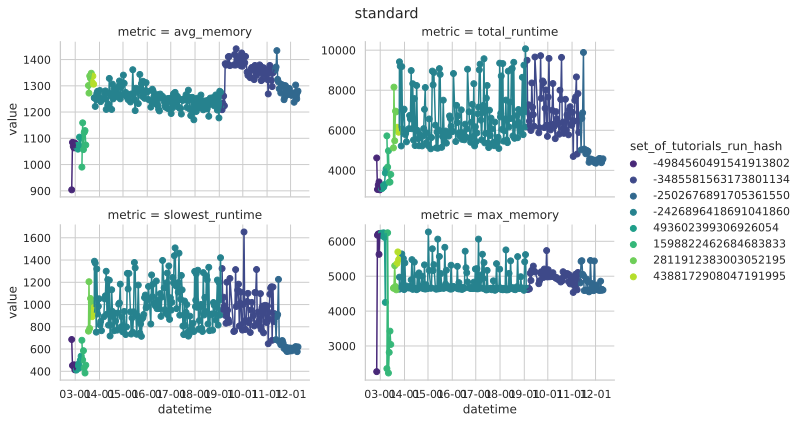

In [11]:
make_time_series_plot(time_series_data_long, "standard")

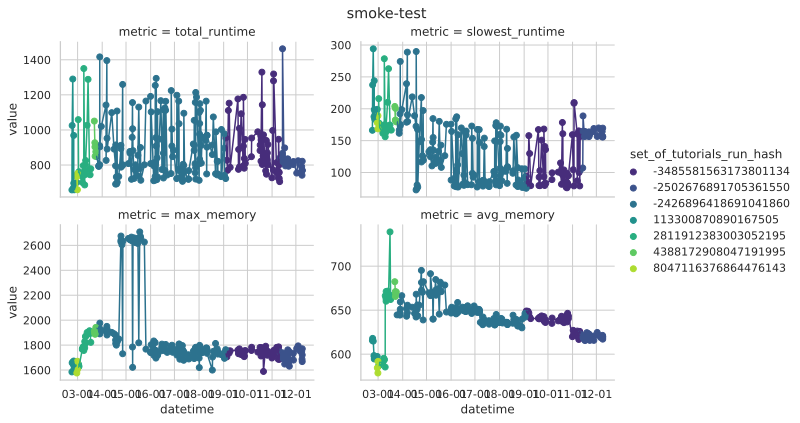

In [12]:
make_time_series_plot(time_series_data_long, "smoke-test")

# Per-tutorial time series plots and histograms

In [13]:
n_days = 7

In [14]:
def make_per_tutorial_ts_plot(mode: str, metric: str):
    idx = (
        df["ran_successfully"] & (df["mode"] == mode)
        & ((df.datetime.max() - df.datetime).dt.days < n_days)
    )
    tutorials_for_ts_plot = df[idx]
    max_metric = tutorials_for_ts_plot.groupby("short_name")[[metric]].max()
    max_metric['rank'] = np.argsort(np.argsort(-max_metric[metric].values))
    tutorials_for_ts_plot = tutorials_for_ts_plot.merge(
        max_metric[["rank"]].reset_index(),
        on="short_name"
    )
    tutorials_for_ts_plot["group"] = tutorials_for_ts_plot["rank"] // 5
    
    fig, axes = plt.subplots(
        tutorials_for_ts_plot["group"].max() + 1, sharex=True, figsize=(5, 10)
    )
    for i, ax in enumerate(axes):
        to_plot = tutorials_for_ts_plot.loc[lambda x: x["group"] == i]
        hue_order = to_plot[["short_name", "rank"]].drop_duplicates().sort_values("rank")["short_name"]
        sns.lineplot(
            data=to_plot,
            x="datetime", y=metric, ax=ax,
            hue="short_name",
            hue_order=hue_order
        )
        sns.scatterplot(
            data=to_plot,
            x="datetime", y=metric, ax=ax,
            hue="short_name",
            hue_order=hue_order,
            legend=False
        )
        ax.legend(bbox_to_anchor=(1, 1))
        ax.set_xticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    sns.despine()
    most_recent = df.datetime.max().date().strftime("%m-%d")
    fig.suptitle(f"{metric} over the {n_days} days up to {most_recent}")

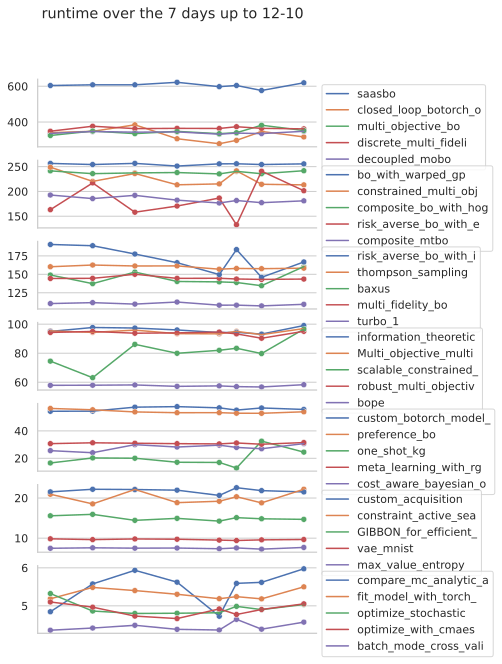

In [15]:
make_per_tutorial_ts_plot("standard", "runtime")

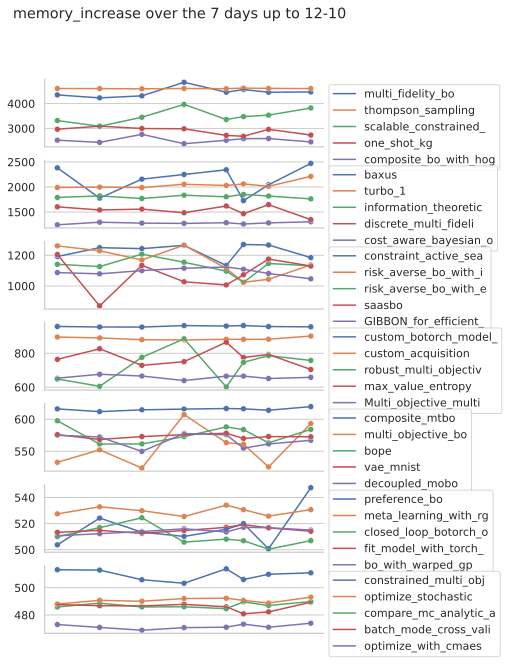

In [16]:
make_per_tutorial_ts_plot("standard", "memory_increase")

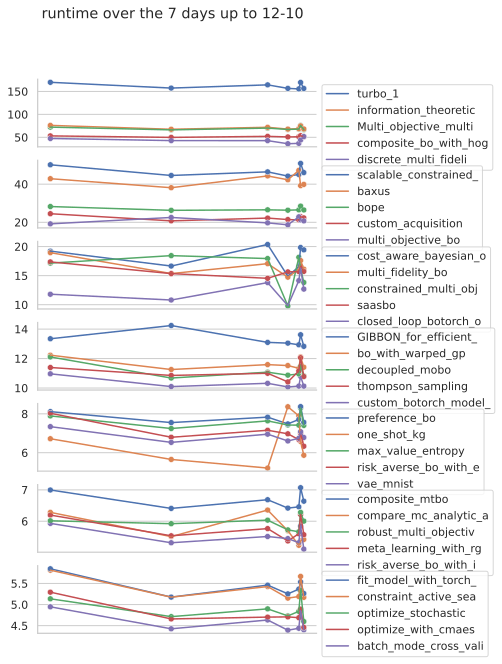

In [17]:
make_per_tutorial_ts_plot("smoke-test", "runtime")

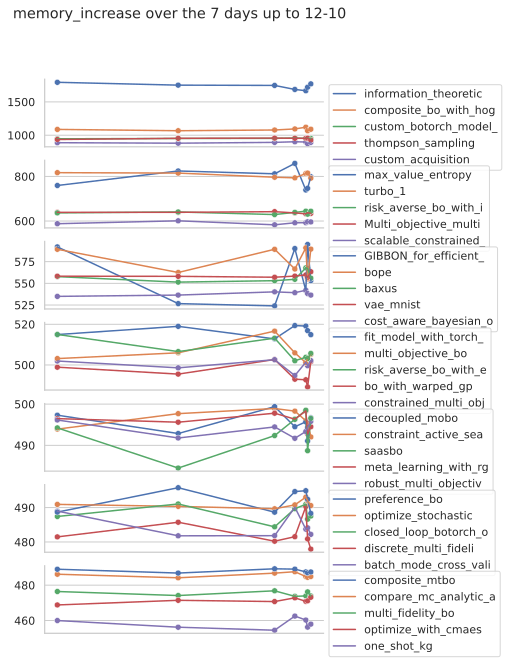

In [18]:
make_per_tutorial_ts_plot("smoke-test", "memory_increase")

# Compare tutorials against each other

In [19]:
last_run_data = df[
    df["datetime"] == df.groupby("mode")["datetime"].transform("max")
].sort_values("memory_increase")
last_run_data_long = pd.melt(
    last_run_data,
    id_vars=["mode", "name"],
    value_vars=["runtime", "memory_increase"],
    var_name="metric",
)
last_run_data_long.head()

,mode,name,metric,value
0,smoke-test,one_shot_kg,runtime,5.867592
1,smoke-test,optimize_with_cmaes,runtime,4.458424
2,smoke-test,multi_fidelity_bo,runtime,16.121423
3,standard,optimize_with_cmaes,runtime,5.051498
4,smoke-test,discrete_multi_fidelity_bo,runtime,51.639137


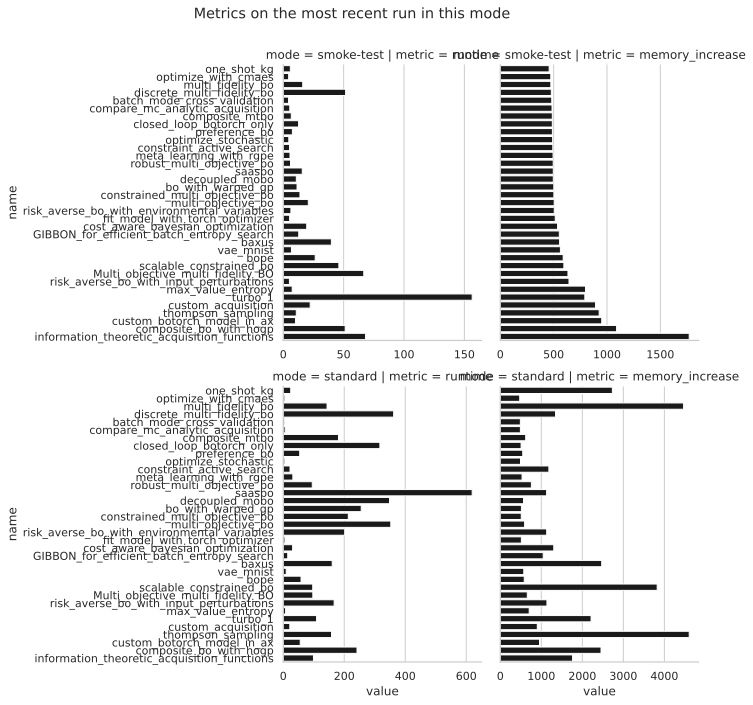

In [20]:
g = sns.catplot(
    data=last_run_data_long,
    col="metric",
    row="mode",
    x="value",
    y="name",
    kind="bar",
    orient="h",
    sharex=False,
    color="k",
)
g.fig.suptitle("Metrics on the most recent run in this mode")
plt.subplots_adjust(top=0.9)